In [121]:
#%config Completer.use_jedi = False

# **Chapter 4**
## *Persisting Time Series Data to Files*, 

This chapter covers different options and use cases to store time series data for later retrieval. The techniques will cover various methods and file types, whether on-premises or in the cloud. In addition, this chapter covers serialization, compression, overwriting, or appending to files. 

We will cover the following recipes on how to ingest data into a pandas DataFrame:
* Time series data serialization with pickle
* Writing to CSV and other delimited files
* Writing data to an Excel file
* Storing data to a private S3 bucket

# Recipe 1: Serializing time series data with pickle
* This recipe explains the concept of data serialization 
* Demonstrate how pickling works 

In [122]:
import pandas as pd

In [123]:
df = pd.read_csv('datasets/time_series_covid19_confirmed_global.csv')

In [124]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/19/21,9/20/21,9/21/21,9/22/21,9/23/21,9/24/21,9/25/21,9/26/21,9/27/21,9/28/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,154487,154585,154712,154757,154800,154960,154960,154960,155072,155093
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,162953,163404,164276,165096,165864,166690,167354,167893,168188,168782
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,201600,201766,201948,202122,202283,202449,202574,202722,202877,203045
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,15124,15140,15140,15153,15156,15167,15167,15167,15189,15192
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,52307,52644,52968,53387,53840,54280,54795,55121,55583,56040


In [125]:
# filter data where Country is United States
df_usa = df[df['Country/Region'] == 'US']
# filter columns from June to end of September
df_usa_summer = df_usa.loc[:, '6/1/20':'9/30/20']
# pivot the data 
df_usa_summer

,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,...,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20
254,1816679,1837948,1857728,1879463,1904375,1925849,1944117,1960815,1978823,2000019,...,6860254,6900324,6939235,6986604,7034971,7079902,7117964,7150631,7194195,7233295


In [126]:
# unpivot using pd.melt()
df_usa_summer_unpivoted = pd.melt(df_usa_summer,
                                  value_vars=df_usa_summer.columns,
                                  value_name='cases',
                                  var_name='date').set_index('date')
df_usa_summer_unpivoted.index = pd.to_datetime(df_usa_summer_unpivoted.index)
df_usa_summer_unpivoted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 2020-06-01 to 2020-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cases   122 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


/tmp/ipykernel_49295/3746536897.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_usa_summer_unpivoted.index = pd.to_datetime(df_usa_summer_unpivoted.index)


In [127]:
df_usa_summer_unpivoted.head()

,cases
date,
2020-06-01,1816679
2020-06-02,1837948
2020-06-03,1857728
2020-06-04,1879463
2020-06-05,1904375


In [128]:
output = 'datasets/covid_usa_summer_2020.pkl'
df_usa_summer_unpivoted.to_pickle(output)

In [129]:
unpickled_df = pd.read_pickle(output)
unpickled_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 2020-06-01 to 2020-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cases   122 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


## Writing a Pickle file using the Pickle library

In [130]:
import pickle

In [131]:
output = 'datasets/covid_usa_summer_2020_v2.pkl'
pickle.dump(df_usa_summer_unpivoted,
           open(output, "wb"))

In [132]:
df = pickle.load(open(output, "rb"))
type(df)

pandas.core.frame.DataFrame

In [133]:
with open(output, "wb") as file:
    pickle.dump(df_usa_summer_unpivoted, file)

In [134]:
with open(output, "rb") as file:
    df = pickle.load(file)

#### Check seriealization protocols

In [135]:
pickle.HIGHEST_PROTOCOL

5

In [136]:
with open(output, "wb") as file:
    pickle.dump(df_usa_summer_unpivoted,
                file,
                pickle.HIGHEST_PROTOCOL)

# this is equivalent to the following
with open(output, "wb") as file:
    pickle.dump(df_usa_summer_unpivoted, file, 5)

## There is more

In [137]:
def covid_by_country(file, days, country):
    ts = pd.read_csv(file)
    ts = ts[ts['Country/Region'] == country]
    final = ts.iloc[:, -days:].sum()
    final.index = pd.to_datetime(final.index)
    return final

/tmp/ipykernel_49295/833238992.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final.index = pd.to_datetime(final.index)


<Axes: title={'center': 'COVID confirmed case for US'}, xlabel='Date', ylabel='Number of Confirmed Cases'>

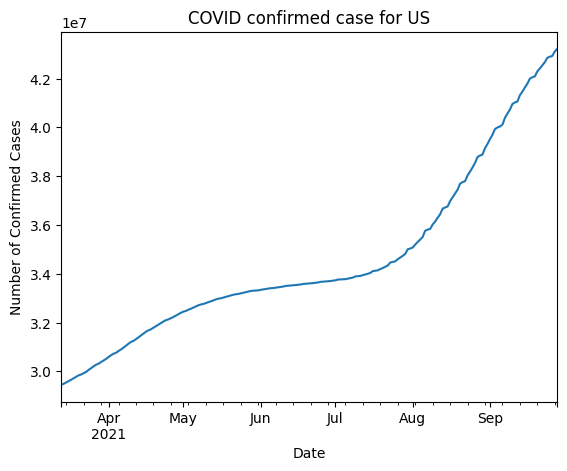

In [138]:
file = 'datasets/time_series_covid19_confirmed_global.csv'
us_past_120_days = covid_by_country(file, 200, 'US')
us_past_120_days.plot(
    title=f'COVID confirmed case for US',
    xlabel='Date',
    ylabel='Number of Confirmed Cases')

In [139]:
from datetime import datetime
metadata = {
    'date': datetime.now(),
    'data': """
        COVID-19 Data Repository by the 
        Center for Systems Science and Engineering (CSSE) 
        at Johns Hopkins University'
        """,
    'author': 'Tarek Atwan',
    'version': 1.0,
    'function': covid_by_country,
    'example' : us_past_120_days
}

output = 'datasets/covid.pkl'
with open(output, 'wb') as file:
    pickle.dump(metadata, file)

In [140]:
with open(output, 'rb') as file:
    content = pickle.load(file)
content.keys()

dict_keys(['date', 'data', 'author', 'version', 'function', 'example'])

In [141]:
file = 'datasets/time_series_covid19_confirmed_global.csv'
new_func = content['function']
new_func(file, 120, 'China').tail()

/tmp/ipykernel_49295/833238992.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final.index = pd.to_datetime(final.index)


2021-09-24    108227
2021-09-25    108266
2021-09-26    108309
2021-09-27    108344
2021-09-28    108386
dtype: int64

In [142]:
content['example'].tail()

2021-09-24    42852871
2021-09-25    42900402
2021-09-26    42931354
2021-09-27    43116442
2021-09-28    43227604
dtype: int64

In [143]:
pickle.HIGHEST_PROTOCOL

5

# Recipe 2: Writing as CSV and other delimited files

In [144]:
import pandas as pd
filepath = 'datasets/movieboxoffice.csv'

movies = pd.read_csv(filepath,
                 header=0,
                 parse_dates=[0],
                 index_col=0,
                 usecols=['Date', 'Daily'])
movies.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128 entries, 2021-04-26 to 2021-08-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Daily   128 non-null    object
dtypes: object(1)
memory usage: 2.0+ KB


/tmp/ipykernel_49295/2913762804.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  movies = pd.read_csv(filepath,


In [145]:
movies.head()

,Daily
Date,
2021-04-26,"$125,789.89"
2021-04-27,"$99,374.01"
2021-04-28,"$82,203.16"
2021-04-29,"$33,530.26"
2021-04-30,"$30,105.24"


In [146]:
movies.to_csv('datasets/my_movies.csv')

In [147]:
output = 'datasets/piped_movies.csv'
movies.to_csv(output, sep='|')

In [148]:
movies_df = pd.read_csv(output, sep='|')

In [149]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    128 non-null    object
 1   Daily   128 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB



### Special cases when using `.to_csv()`

In [150]:
person = pd.DataFrame({
    'name': ['Bond, James', 'Smith, James', 'Bacon, Kevin'],
    'location': ['Los Angeles, CA', 'Phoenix, AZ', 'New York, NY'],
    'net_worth': [10000, 9000, 8000]
})
person

,name,location,net_worth
0,"Bond, James","Los Angeles, CA",10000
1,"Smith, James","Phoenix, AZ",9000
2,"Bacon, Kevin","New York, NY",8000


In [151]:
person.to_csv('person_a.csv', index=False)

In [152]:
import csv

person.to_csv('person_b.csv', 
               index=False, 
               quoting=csv.QUOTE_ALL)
person.to_csv('person_c.csv', 
               index=False, 
               quoting=csv.QUOTE_MINIMAL)
person.to_csv('person_d.csv', 
               index=False, 
               quoting= csv.QUOTE_NONNUMERIC)
person.to_csv('person_e.csv', 
               index=False, 
               quoting= csv.QUOTE_NONE, escapechar='\t')

# Recipe 3: Writing data to an Excel file

In the *Reading data from an Excel file* recipe in **Chapter 2**, *Reading Time Series Data from Files*, you were instructed to install `openpyxl` for the read engine. For this recipe, you will be using the same openpyxl for the write engine.  

* You can also use `pip`:

In [153]:
!pip3 install -Uq openpyxl xlsxwriter

In [154]:
import openpyxl
import xlsxwriter

In [155]:
print(openpyxl.__version__)
print(xlsxwriter.__version__)

3.1.2
3.1.0


In [156]:
output = 'datasets/daily_boxoffice.xlsx'
movies.to_excel(output,
                sheet_name='movies',
                engine='openpyxl')  # default engine for xlsx files

In [157]:
with pd.ExcelWriter(output,  
                    engine='openpyxl',
                    date_format='MM-DD-YYYY',
                    mode='a',
                    if_sheet_exists='new') as writer:
    movies.to_excel(writer, sheet_name='movies_fixed_dates')

In [158]:
movies

,Daily
Date,
2021-04-26,"$125,789.89"
2021-04-27,"$99,374.01"
2021-04-28,"$82,203.16"
2021-04-29,"$33,530.26"
2021-04-30,"$30,105.24"
...,...
2021-08-27,$0.00
2021-08-28,$0.00
2021-08-29,$0.00


In [159]:
movies['Month'] = movies.index.month_name()
movies.head()

,Daily,Month
Date,,
2021-04-26,"$125,789.89",April
2021-04-27,"$99,374.01",April
2021-04-28,"$82,203.16",April
2021-04-29,"$33,530.26",April
2021-04-30,"$30,105.24",April


### Split the DataFrame into multiple sheets by Month

In [160]:
with pd.ExcelWriter('datasets/boxoffice_by_month.xlsx',
                    engine='openpyxl',
                    datetime_format='MM-DD-YYYY') as writer:
    for month, data in movies.groupby('Month'):
        data.to_excel(writer, sheet_name=month)

# Recipe 4: Storing Data to S3
In this recipe, you will explore writing to AWS S3 using pandas and another approach using the AWS Python SDK. The pandas approach can be used to write files to other cloud storage locations, such as Azure or Google Cloud.

In the *Reading data from a URL* recipe in **Chapter 2**, *Reading Time Series Data from Files*, you were instructed to install boto3 and s3fs in order to read from AWS S3 buckets. In this recipe, you will be leveraging the same libraries.

* To install using pip, you can use this:

```
pip3 install -Uq boto3 s3fs
```

In [161]:
import configparser
config = configparser.ConfigParser()
config.read('aws.cfg')

AWS_ACCESS_KEY = config['AWS']['aws_access_key']
AWS_SECRET_KEY = config['AWS']['aws_secret_key']

In [162]:
import pandas as pd
movies = pd.concat(pd.read_excel(
    'datasets/boxoffice_by_month.xlsx',
    sheet_name=None,
    index_col='Date',
    parse_dates=True)).droplevel(0)

In [163]:
movies.to_excel('s3://tscookbook/movies.xlsx',
                sheet_name='Sheet1',
                storage_options={'key': AWS_ACCESS_KEY,
                                 'secret': AWS_SECRET_KEY})
movies.to_csv('s3://tscookbook-private/movies.csv',
               storage_options={'key': AWS_ACCESS_KEY,
                                'secret': AWS_SECRET_KEY})

Exception ignored in: <function ZipFile.__del__ at 0x7f11f940fd80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/zipfile.py", line 1872, in __del__
    self.close()
  File "/usr/local/lib/python3.11/zipfile.py", line 1889, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


ClientError: An error occurred (InvalidAccessKeyId) when calling the PutObject operation: The AWS Access Key Id you provided does not exist in our records.

## There is more
#### Using Boto3 and StringIO

In [ ]:
import boto3
from io import StringIO

bucket = 'tscookbook-private'
s3_client = boto3.resource('s3',
            aws_access_key_id = AWS_ACCESS_KEY,
            aws_secret_access_key = AWS_SECRET_KEY)

with StringIO() as in_memory_buffer:
    movies.to_csv(in_memory_buffer)
    response = s3_client.Object(bucket, 'new_df.csv').put(Body=in_memory_buffer.getvalue())
    status = response['ResponseMetadata']['HTTPStatusCode']
    if status == 200:
        print('Successful Write')
    else:
        print('Unsucessful Write - ', status)

Successful Write
